# 04_feature_selection_handcrafted.ipynb

This notebook performs a **manual feature selection** to generate a concise “short‐list” of predictors for the final model.  
It’s organized in modular steps and can be easily extended later (e.g. SHAP, greedy addition, AutoML).

---

## 1. Setup & Load Data

- Load the full feature matrix (`00_train_features_all.parquet`) with `SK_ID_CURR` and `TARGET`
- Display the data shape


In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, cross_val_score
import lightgbm as lgb

from creditutils.path_utils import get_project_root
from creditutils.feature_selection_utils import evaluate_auc

# Get project root and feature file path
proj_root = get_project_root(levels_up=1)
feat_file = proj_root / "outputs" / "00_train_features_all.parquet"

# Load the dataset
df = pd.read_parquet(feat_file)
print(f"Dataset shape: {df.shape}")

Dataset shape: (307511, 198)


## 2. Basic Filtering: Missingness & Low Variance (numeric features only)

- Replace infinite values with NaN  
- Drop numeric features with **>80% missing values**  
- Drop numeric features that are **constant** or have **near-zero variance**  
- Keep categorical features for later encoding and selection


In [2]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold

# Identify all feature columns (excluding ID and target)
feature_cols = [c for c in df.columns if c not in ["SK_ID_CURR", "TARGET"]]

# Split into numeric vs. non-numeric
numeric_feats = df[feature_cols].select_dtypes(include="number").columns.tolist()
categorical_feats = [c for c in feature_cols if c not in numeric_feats]
print(f"{len(numeric_feats)} numeric features, {len(categorical_feats)} non-numeric features")

# Replace infinite values with NaN (to avoid errors)
df[numeric_feats] = df[numeric_feats].replace([np.inf, -np.inf], np.nan)

# Drop numeric features with high missing rate (>80%)
missing_threshold = 0.8
missing_rate = df[numeric_feats].isna().mean()
to_drop_missing = missing_rate[missing_rate > missing_threshold].index.tolist()

# Drop numeric features with near-zero variance
vt = VarianceThreshold(threshold=1e-5)
vt.fit(df[numeric_feats].fillna(0))
to_drop_low_var = [
    feat for feat, keep in zip(numeric_feats, vt.get_support()) if not keep
]

# Combine and drop from dataframe
to_drop = set(to_drop_missing + to_drop_low_var)
print(f"Dropping {len(to_drop)} numeric features (missing or low variance)")

selected_numeric = [feat for feat in numeric_feats if feat not in to_drop]
df = df[["SK_ID_CURR"] + selected_numeric + ["TARGET"]]
print("New shape after numeric filtering:", df.shape)


176 numeric features, 20 non-numeric features
Dropping 4 numeric features (missing or low variance)
New shape after numeric filtering: (307511, 174)


## 3. Baseline Model: LightGBM with Default Parameters

- Define a quick stratified CV setup
- Compute baseline AUC to serve as a reference, imbalanced yet


In [3]:
# prepare X and y
X = df.drop(columns=["SK_ID_CURR", "TARGET"])
y = df["TARGET"]

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = lgb.LGBMClassifier(random_state=42)

# baseline AUC
evaluate_auc(X, y, model, cv, name="Baseline")

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24643
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 170
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24702
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[Lig

(0.7786601704883787, 0.004209918994311605)

Baseline (handcrafted): AUC = 0.77866 ± 0.00420

## 4. Model-Based Importance Filtering (Elbow Method)

- Train LightGBM on the full data  
- Extract `feature_importances_` (gain)  
- Compute cumulative importance and locate the “elbow”  
- Remove all features beyond the elbow


In [4]:
# a) Train on the full dataset
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)

# b) Sort and compute cumulative sum
imp_sorted = importances.sort_values(ascending=False)
cum_imp = imp_sorted.cumsum() / imp_sorted.sum()

# c) Find the elbow point
from kneed import KneeLocator
kl = KneeLocator(
    x=range(len(cum_imp)),
    y=cum_imp.values,
    curve="concave",
    direction="increasing"
)
cutoff = kl.knee
print(f"Elbow at rank {cutoff}, corresponding to {cum_imp.values[cutoff]:.2%} cumulative importance")

# d) Keep features up to the elbow
selected_feats = imp_sorted.index[:cutoff + 1].tolist()
X_imp = X[selected_feats]
print("Shape after elbow filter:", X_imp.shape)

# e) Evaluate performance
evaluate_auc(X_imp, y, model, cv, name="After Elbow Importance Filter")

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24642
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 170
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
Elbow at rank 56, corresponding to 84.53% cumulative importance
Shape after elbow filter: (307511, 57)
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12574
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 57
[LightGBM] [Info] [binary:BoostFromS

(0.7780832227666579, 0.003953273227641299)

**Key Takeaway:** Using the elbow method, we reduced the feature set to 56 variables (capturing 84 % of total gain) while retaining an AUC of 0.77808 ± 0.00395, demonstrating a strong trade-off between simplicity and performance.


## 5. Correlation Filtering

- Compute absolute pairwise correlations on the filtered feature set  
- For each pair with |corr| > 0.90, drop the feature with lower model importance  
- Re-evaluate AUC on the de-correlated feature set  


In [5]:
# Compute absolute correlation matrix
corr_matrix = X_imp.corr().abs()

# Select upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify features to drop and record their correlation values
drop_info = []
threshold = 0.90
for col in upper.columns:
    for other in upper.index[upper[col] > threshold]:
        corr_val = upper.at[other, col]
        # drop the one with lower importance
        if importances[col] < importances[other]:
            drop_info.append((col, other, corr_val))
        else:
            drop_info.append((other, col, corr_val))

to_drop = list({feat for feat, _, _ in drop_info})

# Print detailed drop list
print("Dropping the following highly correlated features:")
for feat, corr_with, corr_val in drop_info:
    print(f"- {feat} (corr={corr_val:.2f}) with {corr_with}")

# Drop and form final matrix
X_corr = X_imp.drop(columns=to_drop)
print(f"New shape after correlation filter: {X_corr.shape}")

# Evaluate performance after correlation filtering
evaluate_auc(X_corr, y, model, cv, name="After Correlation Filter")


Dropping the following highly correlated features:
- AGE (corr=1.00) with DAYS_BIRTH
- YEARS_EMPLOYED (corr=0.97) with AGE_EMPLOYED_PRODUCT
- DAYS_EMPLOYED (corr=0.97) with AGE_EMPLOYED_PRODUCT
- DAYS_EMPLOYED (corr=1.00) with YEARS_EMPLOYED
- AMT_CREDIT (corr=0.99) with AMT_GOODS_PRICE
- pc_CNT_INSTALMENT_MEAN (corr=0.95) with pc_CNT_INSTALMENT_FUTURE_MEAN
- prev_APP_AGE_MAX (corr=0.92) with pc_MONTHS_BALANCE_MIN
New shape after correlation filter: (307511, 51)
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11044
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive

(0.7786418155790724, 0.004089754958156487)

Correlation filtered AUC: 0.77864 ± 0.00408

## 6. SHAP-Based Feature Elimination

- Compute SHAP values on a held-out test set to estimate feature importance  
- Rank features by mean absolute SHAP value and plot them to see which are the most important
- Iteratively drop the least important features (1 to 20)  
- Re-evaluate AUC after each drop using 5-fold cross-validation  


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11046
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


c:\Users\tgruenecker\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


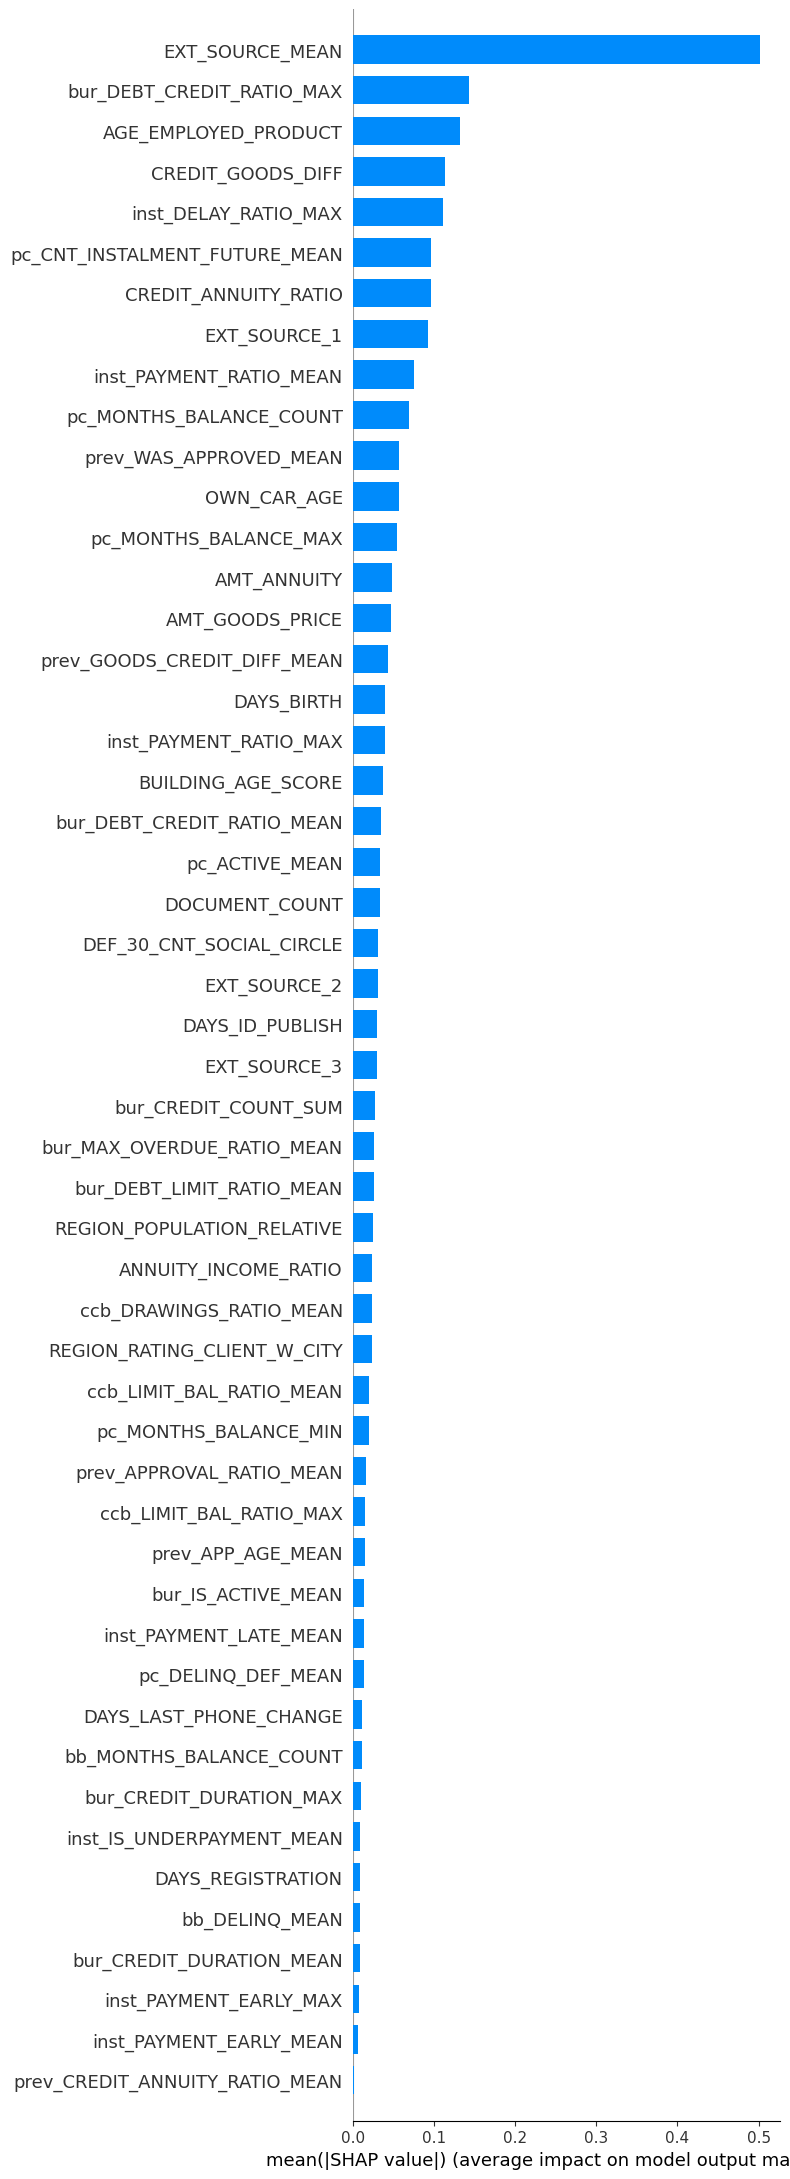

Iterative SHAP Feature Elimination (CV-AUC):
n_dropped | AUC      | STD     | Dropped Features
--------------------------------------------------------------
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10789
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10789
[LightGBM] [Info] Number of data points in the train set: 246009, number of 

In [6]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold

# === Prepare data ===
X = X_corr.copy()
y = df['TARGET']

# Train/test split for SHAP value computation only (not for evaluation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Train model and compute SHAP values ===
def compute_shap_values(model, X_background, X_target):
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_target)
    return shap_vals[1] if isinstance(shap_vals, list) else shap_vals

model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

shap_values = compute_shap_values(model, X_train, X_test)

# SHAP summary plot (bar plot of mean absolute SHAP values)
shap.summary_plot(
    shap_values, X_test,
    plot_type="bar",
    max_display=shap_values.shape[1]
)

# === Iterative SHAP-based feature elimination with CV-AUC evaluation ===
def iteratively_drop_least_important_features(X, y, shap_vals, max_drop=20):
    # Compute mean absolute SHAP value per feature
    mean_shap = np.abs(shap_vals).mean(axis=0)
    feature_ranking = pd.Series(mean_shap, index=X.columns).sort_values()

    model = lgb.LGBMClassifier(random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("Iterative SHAP Feature Elimination (CV-AUC):")
    print("n_dropped | AUC      | STD     | Dropped Features")
    print("--------------------------------------------------------------")

    for n in range(1, max_drop + 1):
        to_drop = feature_ranking.index[:n].tolist()
        X_reduced = X.drop(columns=to_drop)
        mean_auc, std_auc = evaluate_auc(X_reduced, y, model, cv, verbose=False)
        print(f"{n:<9} | {mean_auc:.5f} | {std_auc:.5f} | {', '.join(to_drop)}")

# Run elimination for up to 20 least important features
iteratively_drop_least_important_features(X, y, shap_values, max_drop=20)


### Final Feature Selection Decision

While 7 dropped features had the best overall AUC (0.77871), dropping 12 features was chosen because of a still better AUC (0.77839) than before the SHAP-drop and better interpretability.

Therefore, **the following 12 features** will be **removed** from the final feature set:

`prev_CREDIT_ANNUITY_RATIO_MEAN`, `inst_PAYMENT_EARLY_MEAN`, `inst_PAYMENT_EARLY_MAX`, `bur_CREDIT_DURATION_MEAN`, `bb_DELINQ_MEAN`, `DAYS_REGISTRATION`, `inst_IS_UNDERPAYMENT_MEAN`, `bur_CREDIT_DURATION_MAX`, `bb_MONTHS_BALANCE_COUNT`, `DAYS_LAST_PHONE_CHANGE`, `pc_DELINQ_DEF_MEAN`, `inst_PAYMENT_LATE_MEAN`

Notably, `EXT_SOURCE_MEAN` was identified as the most important feature by SHAP. Since this variable has around 20% missing values, it might be valuable to train a separate model to impute or predict `EXT_SOURCE_MEAN` based on the available features.

The final feature set has now 39 features.

## 6. Export Selected Features

- Save the features as `01_train_features_first_baseline.parquet`


In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

from creditutils.path_utils import get_project_root
from creditutils.feature_selection_utils import evaluate_auc

# Number of features to drop based on SHAP importance
n_drop = 12

# Compute mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_ranking = pd.Series(mean_abs_shap, index=X.columns).sort_values()

# Select the n_drop features with the lowest SHAP importance
to_drop = shap_ranking.index[:n_drop].tolist()
print(f"Dropping {n_drop} features with lowest SHAP importance:\n{to_drop}")

# Create reduced feature set by dropping selected features
X_final = X.drop(columns=to_drop)
y_final = df["TARGET"]

# Set up model and cross-validation
model = lgb.LGBMClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate AUC via cross-validation
mean_auc, std_auc = evaluate_auc(
    X_final, y_final, model, cv, name="Final Reduced Model"
)

# Combine SK_ID_CURR, TARGET, and reduced features
df_final = pd.concat([df[["SK_ID_CURR", "TARGET"]], X_final], axis=1)

# Save final training feature set
proj_root = get_project_root(levels_up=1)
output_dir = proj_root / "outputs"
output_dir.mkdir(parents=True, exist_ok=True)

train_path = output_dir / "01_train_features_first_baseline.parquet"
df_final.to_parquet(train_path, index=False)
print(f"Final training feature set saved to: {train_path}")

# --- Match test set to reduced features ---
# Load full test set
test_path_full = output_dir / "00_test_features_all.parquet"
test_df = pd.read_parquet(test_path_full)

# Use same feature columns as in training
final_features = X_final.columns.tolist()
test_df_final = test_df[["SK_ID_CURR"] + final_features].copy()

# Save final test feature set
test_path = output_dir / "01_test_features_first_baseline.parquet"
test_df_final.to_parquet(test_path, index=False)
print(f"Final test feature set saved to: {test_path}")

Dropping 12 features with lowest SHAP importance:
['prev_CREDIT_ANNUITY_RATIO_MEAN', 'inst_PAYMENT_EARLY_MEAN', 'inst_PAYMENT_EARLY_MAX', 'bur_CREDIT_DURATION_MEAN', 'bb_DELINQ_MEAN', 'DAYS_REGISTRATION', 'inst_IS_UNDERPAYMENT_MEAN', 'bur_CREDIT_DURATION_MAX', 'bb_MONTHS_BALANCE_COUNT', 'DAYS_LAST_PHONE_CHANGE', 'pc_DELINQ_DEF_MEAN', 'inst_PAYMENT_LATE_MEAN']
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7986
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

## 7. Logging with Weights & Biases (wandb)

- Initialize a new Weights & Biases run to track this feature selection stage  
- Log cross-validated AUC and standard deviation of the final reduced model  
- Log the number of selected features (`n_features`)  
- Store the full list of selected feature names in the run summary for reference  


In [10]:
import wandb

# Initialize wandb run
wandb.init(
    project="home_credit_default",
    name="01_first_baseline_ext_filled",
    config={
        "model": "lightgbm",
        "selection": "SHAP + Elbow + Correlation",
    }
)

# Log scalar metrics
wandb.log({
    "auc": mean_auc,
    "cv_std": std_auc,
    "n_features": X_final.shape[1],
})

# Log feature names as summary
wandb.summary["feature_names"] = X_final.columns.tolist()

wandb.finish()

auc,▁
cv_std,▁
n_features,▁
auc,0.77839
cv_std,0.00384
n_features,39
